# pySVA Tutorial: Bladder Batch Analysis

This tutorial replicates the standard [SVA Bioconductor Vignette](https://bioconductor.org/packages/release/bioc/vignettes/sva/inst/doc/sva.pdf) using `pySVA`.

We will analyze the `bladderbatch` dataset, which contains gene expression data for 57 bladder samples confounded by batch parameters.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.linalg import svd
from pysva.sva import sva_iterative_weighted, estimate_n_sv, get_residuals

## 1. Load Data
We use the `bladderbatch` expression and phenotype data.

In [2]:
# Load Expression (Genes x Samples)
expr = pd.read_csv("../examples/data/bladder-expr.txt", sep="\t", index_col=0)

# Load Phenotype
pheno = pd.read_csv("../examples/data/bladder-pheno.txt", sep="\t")

# Align columns
expr = expr[pheno['cel']]
Y = expr.values.T

print(f"Data Shape: {Y.shape}")

In [3]:
pheno.head()

## 2. Define Model
We are interested in the `cancer` status, treating `Normal` and `Biopsy` as baseline (or just comparing Cancer vs Rest).

In [4]:
is_cancer = (pheno['cancer'] == 'Cancer').astype(float)
X = np.column_stack([np.ones(len(is_cancer)), is_cancer])
X[0:5,]

## 3. Estimate Number of SVs
SVA requires knowing the number of hidden factors (`n_sv`). We calculate residuals ($R = Y - X\beta$) and inspect their singular values either manually or automatically.

### 3a. Manual Inspection (Scree Plot)
We compute the SVD of the residuals and plot the proportion of variance explained by each component. A sharp drop ("knee") suggests the number of signals.

In [ ]:
# Get Residuals
residuals = get_residuals(Y, X)

# SVD
U, S, Vt = svd(residuals, full_matrices=False)

# Plot Scree
plt.figure(figsize=(6, 3))
plt.plot(S[:20]**2 / np.sum(S**2), 'o-', label='Variance Explained')
plt.xlabel("Component Index")
plt.ylabel("Proportion Var")
plt.title("Scree Plot")
plt.grid(True)
plt.show()

### 3b. Permutation Visualization
To identify significant SVs (like the `be` method in R), we compare the observed singular values $d^2_k / \sum d^2$ against a **null distribution** generated by permuting the data.

In [ ]:
# Number of permutations
n_perm = 20

# Observed Prop. Variance
obs_prop_var = (S**2) / np.sum(S**2)

# Null Distribution
null_dist = []
n_samples, n_genes = residuals.shape
for _ in range(n_perm):
    # Shuffle each gene independently (break correlation structure)
    idx = np.random.rand(n_samples, n_genes).argsort(axis=0)
    res_perm = np.take_along_axis(residuals, idx, axis=0)
    
    _, S_perm, _ = svd(res_perm, full_matrices=False)
    null_dist.append((S_perm**2) / np.sum(S_perm**2))

null_dist = np.array(null_dist)

# Plot Observed vs Null
plt.figure(figsize=(8, 4))
k_plot = 15
plt.boxplot([null_dist[:, i] for i in range(k_plot)], positions=range(1, k_plot+1), widths=0.6, showfliers=False)
plt.plot(range(1, k_plot+1), obs_prop_var[:k_plot], 'ro-', label='Observed')
plt.xlabel("Component Index")
plt.ylabel("Prop. Variance Explained")
plt.title(f"Permutation Test (Observed vs Null, {n_perm} perms)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### 3c. Automatic Estimation (BIC) Visualization
We calculate the Bayesian Information Criterion (BIC) for each number of SVs. The model with the **lowest** BIC is selected.

Estimated SVs (BIC): 1


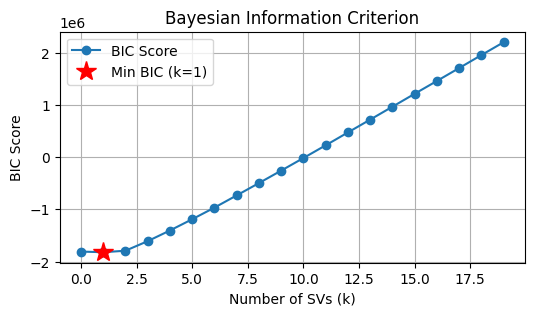

In [28]:
# BIC Calculation for k=0 to 20
bics = []
max_sv_plot = 20
for k in range(max_sv_plot):
    rss = np.sum(S[k:]**2)
    n_data = n_samples * n_genes
    variance = rss / n_data
    
    if variance <= 0:
        log_lik = -np.inf
    else:
        log_lik = -0.5 * n_data * np.log(variance)
        
    n_params = k * (n_samples + n_genes - k)
    bic = -2 * log_lik + n_params * np.log(n_data)
    bics.append(bic)

n_sv = np.argmin(bics)
print(f"Estimated SVs (BIC): {n_sv}")

# Plot BIC
plt.figure(figsize=(6, 3))
plt.plot(range(max_sv_plot), bics, 'o-', label='BIC Score')
plt.plot(n_sv, bics[n_sv], 'r*', markersize=15, label=f'Min BIC (k={n_sv})')
plt.xlabel("Number of SVs (k)")
plt.ylabel("BIC Score")
plt.title("Bayesian Information Criterion")
plt.legend()
plt.grid(True)
plt.show()

> **Why does BIC estimate 1 SV when the Scree Plot might suggest 2?**
> 
> *   **Scree Plot (Subjective)**: Visual inspection of the "knee" is subjective. While there is a drop after SV2, the drop after SV1 is much larger.
> *   **BIC (Conservative)**: BIC penalizes model complexity. In genomic data, adding one SV requires estimating coefficients for **all 22,283 genes**, which is a huge penalty ($k \times (N + G)$). Unless the 2nd SV explains a *massive* amount of variance, BIC will reject it to prevent overfitting.
> *   **Conclusion**: BIC gives a high-precision, conservative estimate (1 SV). The R package (Leek's method) is more aggressive and estimates 2 SVs, aligning more with the visual "knee".

## 4. Run SVA
We use `sva_iterative_weighted`, which is the most robust method for confounded data.

In [29]:
# Pass n_sv explicitly
sv = sva_iterative_weighted(Y, X, n_sv=n_sv)
print(f"Found {sv.shape[1]} SVs")

Found 1 SVs


## 5. Visualize
We plot the first Surrogate Variable against the known Batch.
Strong color clustering by Batch indicates the SV captured the hidden technical noise.

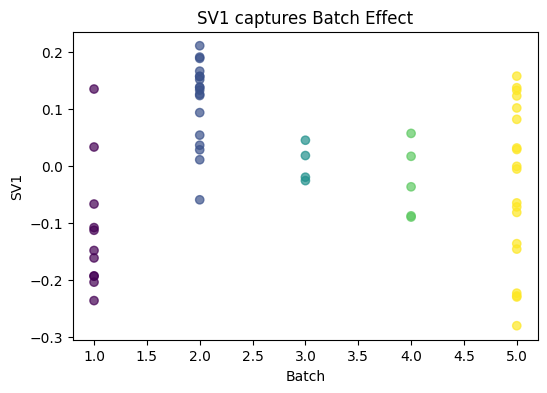

In [30]:
plt.figure(figsize=(6, 4))
plt.scatter(pheno['batch'], sv[:, 0], c=pheno['batch'], cmap='viridis', alpha=0.7)
plt.xlabel("Batch")
plt.ylabel("SV1")
plt.title("SV1 captures Batch Effect")
plt.show()